# Code for CNN and Bi-LSTM

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Load the Hugging Face Emotion Dataset
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")



No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/HP/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
# Extract unique samples from the dataset
import numpy as np
train_texts = []
train_labels = []

for text, label in zip(dataset["train"]["text"], dataset["train"]["label"]):
    if text not in train_texts:
        train_texts.append(text)
        train_labels.append(label)


val_texts = []
val_labels = []

for text, label in zip(dataset["validation"]["text"], dataset["validation"]["label"]):
    if text not in val_texts:
        val_texts.append(text)
        val_labels.append(label)


test_texts = []
test_labels = []

for text, label in zip(dataset["test"]["text"], dataset["test"]["label"]):
    if text not in test_texts:
        test_texts.append(text)
        test_labels.append(label)


In [3]:
train_texts

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [4]:
import pandas as pd
df_train = pd.DataFrame({'text':train_texts,'label':train_labels})
df_test = pd.DataFrame({'text':test_texts,'label':test_labels})
df_val = pd.DataFrame({'text':val_texts,'label':val_labels})

In [5]:
def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def normalize_text(df):
    df.text=df.text.apply(lambda text : Removing_numbers(text))
    df.text=df.text.apply(lambda text : Removing_punctuations(text))
    df.text=df.text.apply(lambda text : Removing_urls(text))
    return df
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)

In [8]:
#print the number of duplicated values 
df_train.duplicated().sum()

83

In [9]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [10]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['text'].duplicated() == True]

,text,label
3781,feel helpless,4
4607,im feeling stressed,3
7213,feel accepted,1
7644,feel weird,4
10012,feel overwhelmed,5
12726,feel agitated,4
15280,feeling stressed,3


In [11]:
#print some of those rows to check
df_train[df_train['text'] == df_train.iloc[10012]['text']]

,text,label
7687,feel overwhelmed,4
10012,feel overwhelmed,5


In [12]:
#removing duplicated text 
index = df_train[df_train['text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [13]:
#check if the data is balanced or not
df_train.label.value_counts()

1    5330
0    4633
3    2136
4    1920
2    1294
5     566
Name: label, dtype: int64

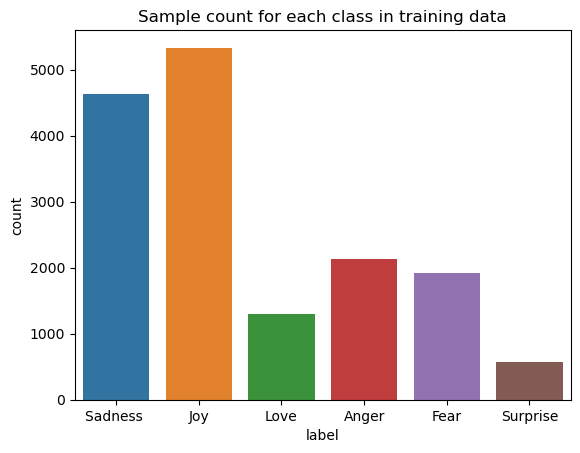

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a count plot
ax = sns.countplot(x='label', data=df_train)

# Set custom label names
ax.set_xticklabels(['Sadness ', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])

# Set a heading
ax.set_title('Sample count for each class in training data')

# Show the plot
plt.show()

In [15]:
#print the number of duplicated values 
df_val.duplicated().sum()

0

In [16]:
#removing duplicated values
index = df_val[df_val.duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [17]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_val[df_val['text'].duplicated() == True]

,text,label
773,feel tortured,4


In [18]:
#print some of those rows to check
df_val[df_val['text'] == df_val.iloc[773]['text']]

,text,label
429,feel tortured,3
773,feel tortured,4


In [19]:
#removing duplicated text 
index = df_val[df_val['text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [20]:
#check if the data is balanced or not
df_val.label.value_counts()

1    703
0    550
3    274
4    211
2    178
5     81
Name: label, dtype: int64

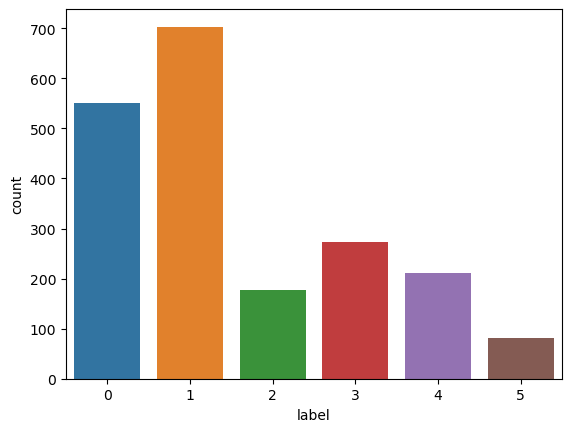

In [21]:
# plt.figure(figsize=(8,4))
sns.countplot(x='label', data=df_val);

In [22]:
train_texts = df_train['text']
test_texts = df_test['text']
val_texts = df_val['text']
train_labels = df_train['label']
test_labels = df_test['label']
val_labels = df_val['label']

In [23]:
# Tokenize the texts
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

D:\App\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [24]:
# Convert labels to categorical format
num_classes = len(dataset["train"].features["label"].names)
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)

In [25]:
train_labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [26]:
# Pad the input sequences
train_input_ids = pad_sequences(train_encodings["input_ids"], maxlen=128, dtype="long", truncating="post", padding="post")
test_input_ids = pad_sequences(test_encodings["input_ids"], maxlen=128, dtype="long", truncating="post", padding="post")
val_input_ids = pad_sequences(val_encodings["input_ids"], maxlen=128, dtype="long", truncating="post", padding="post")

In [27]:
train_input_ids

array([[  101,  2134,  2102, ...,     0,     0,     0],
       [  101,  2175,  3110, ...,     0,     0,     0],
       [  101, 10047,  9775, ...,     0,     0,     0],
       ...,
       [  101,  2514,  2844, ...,     0,     0,     0],
       [  101,  2514,  2066, ...,     0,     0,     0],
       [  101,  2113,  2843, ...,     0,     0,     0]])

In [28]:
# Define the CNN model
model = Sequential([
    Embedding(tokenizer.vocab_size, 32, input_length=128),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

model_L = Sequential()
model_L.add(Embedding(tokenizer.vocab_size,32, input_length=128))
model_L.add(Bidirectional(LSTM(20, return_sequences = True)))
model_L.add(Bidirectional(LSTM(20)))
model_L.add(Dense(num_classes, activation = 'softmax'))

model_L.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [30]:
train_input_ids.shape, train_labels.shape, val_input_ids.shape, val_labels.shape

((15879, 128), (15879, 6), (1997, 128), (1997, 6))

In [31]:
# Train the model
model.fit(train_input_ids, train_labels, validation_data=(val_input_ids, val_labels),batch_size = 32, epochs=5)

Epoch 1/5
497/497 [==============================] - 15s 26ms/step - loss: 0.8815 - accuracy: 0.6665 - val_loss: 0.2408 - val_accuracy: 0.9084
Epoch 2/5
497/497 [==============================] - 13s 25ms/step - loss: 0.1493 - accuracy: 0.9431 - val_loss: 0.1942 - val_accuracy: 0.9219
Epoch 3/5
497/497 [==============================] - 13s 26ms/step - loss: 0.0653 - accuracy: 0.9766 - val_loss: 0.2287 - val_accuracy: 0.9139
Epoch 4/5
497/497 [==============================] - 13s 25ms/step - loss: 0.0362 - accuracy: 0.9868 - val_loss: 0.2610 - val_accuracy: 0.9144
Epoch 5/5
497/497 [==============================] - 13s 25ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.2827 - val_accuracy: 0.9179


In [32]:
# Train the model
model_L.fit(train_input_ids, train_labels, validation_data=(val_input_ids, val_labels),batch_size = 32, epochs=5)

Epoch 1/5
261/497 [==============>...............] - ETA: 38s - loss: 1.4373 - accuracy: 0.4325

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
_, accuracy = model.evaluate(test_input_ids, test_labels)
print(f"Accuracy: {accuracy}")

In [ ]:
# Evaluate the model
_, accuracy = model_L.evaluate(test_input_ids, test_labels)
print(f"Accuracy: {accuracy}")

In [ ]:
# Make predictions
example_texts = ["I am happy", "I feel sad"]
example_encodings = tokenizer(example_texts, truncation=True, padding=True)
example_input_ids = pad_sequences(example_encodings["input_ids"], maxlen=128, dtype="long", truncating="post", padding="post")
example_predictions = model.predict(example_input_ids)
predicted_labels = [dataset["train"].features["label"].names[pred.argmax()] for pred in example_predictions]
print("Predicted emotions:")
for text, label in zip(example_texts, predicted_labels):
    print(f"{text}: {label}")

In [ ]:
pred_CNN = model.predict(test_input_ids)
pred_LSTM = model_L.predict(test_input_ids)

In [ ]:
from sklearn.metrics import accuracy_score

Actual = []
Predicted_CNN = []
Predicted_LSTM = []
for i in test_labels:
    Actual.append(np.argmax(i))
for j in pred_CNN:
    Predicted_CNN.append(np.argmax(j))

for j in pred_LSTM:
    Predicted_LSTM.append(np.argmax(j))
        

In [ ]:
from sklearn.metrics import classification_report

print("The Classification Report for the CNN model is:\n",classification_report(Actual,Predicted_CNN))

In [ ]:
print("The Classifcation Report for the Bi-LSTM model is:\n",classification_report(Actual,Predicted_LSTM))